## Models

### Importing packages

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import pandas as pd 
import numpy as np 
import tensorflow as tf 
from sklearn.model_selection import KFold, train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import classification_report, accuracy_score 
from transformers import BertForSequenceClassification, BertTokenizer 
import time 
import torch
from tqdm import tqdm 
from torch.optim import AdamW 
import gc 
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import confusion_matrix 
import seaborn as sns 
import matplotlib.pyplot as plt 
import torch.nn.functional as F 


### Importing cleaned dataset

In [2]:
df = pd.read_csv('/content/clean_resume_dataset.csv')
df

,Category,Resume,clean_text
0,Accountant,education omba executive leadership university...,education omba executive leadership bachelor ...
1,Accountant,howard gerrard accountant deyjobcom birmingham...,accountant deyjobcom infodayjobcom linkedinn...
2,Accountant,kevin frank senior accountant inforesumekraftc...,senior accountant inforesumekraftcom chicago ...
3,Accountant,place birth nationality olivia ogilvy accounta...,place birth nationality olivia accountant 151...
4,Accountant,stephen greet cpa senior accountant 9 year exp...,cpa senior accountant year experience establi...
...,...,...,...
12239,Testing,Computer Skills: â¢ Proficient in MS office (...,in MS office Word Basic Excel Power point wo...
12240,Testing,â Willingness to accept the challenges. â ...,Willingness to accept the challenges Positive ...
12241,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",PERSONAL SKILLS Quick learner Eagerness to lea...
12242,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,COMPUTER SKILLS SOFTWARE KNOWLEDGE wind I nt...


In [3]:
# Get the lengths of all documents
text_lengths = df['clean_text'].apply(lambda x: len(x.split()))

# Get statistics about the lengths
print(f"Max Length: {text_lengths.max()}")
print(f"Min Length: {text_lengths.min()}")
print(f"Average Length: {text_lengths.mean()}")


Max Length: 6146
Min Length: 4
Average Length: 439.7765436131983


In [4]:

# --- Step 3: Encode Labels ---
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Category'])
num_labels = len(label_encoder.classes_)
print(f"Number of unique job roles: {num_labels}")
label_encoder.classes_

# --- Step 4: Train-Test Split (First Split) ---
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['label'],
    test_size=0.1,  # 10% for testing
    random_state=42,
    stratify=df['label']  # Ensures class balance
)

# --- Step 5: Tokenize Text for BERT ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_labels


Number of unique job roles: 43


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using device: cuda


43

### BASE MODEL

In [ ]:

# --- Configuration ---
EPOCHS = 3
BATCH_SIZE = 16
MAX_LENGTH = 128
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01

# --- Step 6: Cross-Validation Setup ---
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
precisions = []
recalls = []
f1_scores = []
fold_results = []

# --- Step 7: K-Fold Cross-Validation ---
for train_index, val_index in kfold.split(X_train):
    print(f"\nTraining fold {fold_no}...")

    # Track time for this fold
    start_time = time.time()

    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    train_encodings = tokenizer(
        list(X_train_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    val_encodings = tokenizer(
        list(X_val_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train_fold.values)
    )

    val_dataset = torch.utils.data.TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(y_val_fold.values)
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # --- Load Model (PyTorch version) ---
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # --- Optimizer & Scheduler ---
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * EPOCHS
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1e-6,
        end_factor=1.0,
        total_iters=total_steps
    )

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')

        # Training
        model.train()
        total_train_loss = 0
        train_pbar = tqdm(train_loader, desc='Training')

        for batch in train_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            model.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')

    # --- Final Evaluation ---
    model.eval()
    final_preds = []
    final_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            final_preds.extend(preds.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    report = classification_report(
        final_labels,
        final_preds,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    fold_result = {
        'fold': fold_no,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'time': time.time() - start_time,
        'report': report
    }

    fold_results.append(fold_result)

    print(f"\n{'='*60}")
    print(f"Fold {fold_no} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Recall:    {report['macro avg']['recall']:.4f}")
    print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
    print(f"  Time:      {fold_result['time']:.2f}s")
    print(f"{'='*60}")

    fold_no += 1

    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# --- Final Results ---
print(f"\n{'='*60}")
print("FINAL K-FOLD CROSS-VALIDATION RESULTS")
print(f"{'='*60}")

accuracies = [f['accuracy'] for f in fold_results]
precisions = [f['precision'] for f in fold_results]
recalls = [f['recall'] for f in fold_results]
f1_scores = [f['f1_score'] for f in fold_results]

print(f"\nAccuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print(f"\nTotal Time: {sum(f['time'] for f in fold_results):.2f}s")
print(f"Average Time per Fold: {np.mean([f['time'] for f in fold_results]):.2f}s")


Using device: cuda

Training fold 1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


Train Loss: 3.6468
Val Loss: 3.1894
Val Accuracy: 0.3077

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:27<00:00,  8.25it/s]


Train Loss: 2.4556
Val Loss: 1.6782
Val Accuracy: 0.7335

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


Train Loss: 1.3433
Val Loss: 1.1101
Val Accuracy: 0.7708

Fold 1 Results:
  Accuracy:  0.7708
  Precision: 0.7493
  Recall:    0.7445
  F1-Score:  0.7398
  Time:      742.18s

Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


Train Loss: 3.6127
Val Loss: 3.0554
Val Accuracy: 0.4816

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


Train Loss: 2.3660
Val Loss: 1.6196
Val Accuracy: 0.7343

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


Train Loss: 1.3001
Val Loss: 1.0744
Val Accuracy: 0.7860

Fold 2 Results:
  Accuracy:  0.7860
  Precision: 0.8086
  Recall:    0.7654
  F1-Score:  0.7738
  Time:      739.98s

Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  8.21it/s]


Train Loss: 3.6239
Val Loss: 3.0847
Val Accuracy: 0.4179

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


Train Loss: 2.3830
Val Loss: 1.6015
Val Accuracy: 0.7465

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


Train Loss: 1.3168
Val Loss: 1.0527
Val Accuracy: 0.7852

Fold 3 Results:
  Accuracy:  0.7852
  Precision: 0.7567
  Recall:    0.7538
  F1-Score:  0.7500
  Time:      740.21s

FINAL K-FOLD CROSS-VALIDATION RESULTS

Accuracy:  0.7807 ± 0.0070
Precision: 0.7715 ± 0.0264
Recall:    0.7545 ± 0.0086
F1-Score:  0.7545 ± 0.0142

Total Time: 2222.36s
Average Time per Fold: 740.79s


### Ablation studies: Batch size 16 -> Batch size 32

In [ ]:
# --- Configuration ---
EPOCHS = 3
BATCH_SIZE = 32
MAX_LENGTH = 128
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01

# --- Step 6: Cross-Validation Setup ---
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
precisions = []
recalls = []
f1_scores = []
fold_results = []

# --- Step 7: K-Fold Cross-Validation ---
for train_index, val_index in kfold.split(X_train):
    print(f"\nTraining fold {fold_no}...")

    # Track time for this fold
    start_time = time.time()

    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    train_encodings = tokenizer(
        list(X_train_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    val_encodings = tokenizer(
        list(X_val_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train_fold.values)
    )

    val_dataset = torch.utils.data.TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(y_val_fold.values)
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # --- Load Model (PyTorch version) ---
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # --- Optimizer & Scheduler ---
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * EPOCHS
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1e-6,
        end_factor=1.0,
        total_iters=total_steps
    )

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')

        # Training
        model.train()
        total_train_loss = 0
        train_pbar = tqdm(train_loader, desc='Training')

        for batch in train_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            model.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')

    # --- Final Evaluation ---
    model.eval()
    final_preds = []
    final_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            final_preds.extend(preds.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    report = classification_report(
        final_labels,
        final_preds,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    fold_result = {
        'fold': fold_no,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'time': time.time() - start_time,
        'report': report
    }

    fold_results.append(fold_result)

    print(f"\n{'='*60}")
    print(f"Fold {fold_no} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Recall:    {report['macro avg']['recall']:.4f}")
    print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
    print(f"  Time:      {fold_result['time']:.2f}s")
    print(f"{'='*60}")

    fold_no += 1

    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# --- Final Results ---
print(f"\n{'='*60}")
print("FINAL K-FOLD CROSS-VALIDATION RESULTS")
print(f"{'='*60}")

accuracies = [f['accuracy'] for f in fold_results]
precisions = [f['precision'] for f in fold_results]
recalls = [f['recall'] for f in fold_results]
f1_scores = [f['f1_score'] for f in fold_results]

print(f"\nAccuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print(f"\nTotal Time: {sum(f['time'] for f in fold_results):.2f}s")
print(f"Average Time per Fold: {np.mean([f['time'] for f in fold_results]):.2f}s")



Training fold 1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 115/115 [00:25<00:00,  4.51it/s]


Train Loss: 3.7242
Val Loss: 3.4705
Val Accuracy: 0.1865

Epoch 2/3


Validation: 100%|██████████| 115/115 [00:25<00:00,  4.51it/s]


Train Loss: 2.8870
Val Loss: 2.1551
Val Accuracy: 0.6638

Epoch 3/3


Validation: 100%|██████████| 115/115 [00:25<00:00,  4.52it/s]


Train Loss: 1.6913
Val Loss: 1.2881
Val Accuracy: 0.7563

Fold 1 Results:
  Accuracy:  0.7563
  Precision: 0.7406
  Recall:    0.7295
  F1-Score:  0.7201
  Time:      697.87s

Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 115/115 [00:25<00:00,  4.51it/s]


Train Loss: 3.6635
Val Loss: 3.3257
Val Accuracy: 0.2287

Epoch 2/3


Validation: 100%|██████████| 115/115 [00:25<00:00,  4.51it/s]


Train Loss: 2.8128
Val Loss: 2.0977
Val Accuracy: 0.6545

Epoch 3/3


Validation: 100%|██████████| 115/115 [00:25<00:00,  4.53it/s]


Train Loss: 1.7126
Val Loss: 1.2839
Val Accuracy: 0.7550

Fold 2 Results:
  Accuracy:  0.7550
  Precision: 0.7283
  Recall:    0.7172
  F1-Score:  0.7093
  Time:      698.41s

Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 115/115 [00:25<00:00,  4.52it/s]


Train Loss: 3.6868
Val Loss: 3.3840
Val Accuracy: 0.2238

Epoch 2/3


Validation: 100%|██████████| 115/115 [00:25<00:00,  4.52it/s]


Train Loss: 2.8155
Val Loss: 2.0786
Val Accuracy: 0.6654

Epoch 3/3


Validation: 100%|██████████| 115/115 [00:25<00:00,  4.52it/s]


Train Loss: 1.6991
Val Loss: 1.2592
Val Accuracy: 0.7686

Fold 3 Results:
  Accuracy:  0.7686
  Precision: 0.7500
  Recall:    0.7353
  F1-Score:  0.7332
  Time:      696.67s

FINAL K-FOLD CROSS-VALIDATION RESULTS

Accuracy:  0.7600 ± 0.0061
Precision: 0.7396 ± 0.0089
Recall:    0.7273 ± 0.0075
F1-Score:  0.7209 ± 0.0098

Total Time: 2092.95s
Average Time per Fold: 697.65s


### Ablation Studies: Max length 128 -> Max length 256

In [ ]:
# --- Configuration ---
EPOCHS = 3
BATCH_SIZE = 16
MAX_LENGTH = 256
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01

# --- Step 6: Cross-Validation Setup ---
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
precisions = []
recalls = []
f1_scores = []
fold_results = []

# --- Step 7: K-Fold Cross-Validation ---
for train_index, val_index in kfold.split(X_train):
    print(f"\nTraining fold {fold_no}...")

    # Track time for this fold
    start_time = time.time()

    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    train_encodings = tokenizer(
        list(X_train_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    val_encodings = tokenizer(
        list(X_val_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train_fold.values)
    )

    val_dataset = torch.utils.data.TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(y_val_fold.values)
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # --- Load Model (PyTorch version) ---
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # --- Optimizer & Scheduler ---
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * EPOCHS
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1e-6,
        end_factor=1.0,
        total_iters=total_steps
    )

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')

        # Training
        model.train()
        total_train_loss = 0
        train_pbar = tqdm(train_loader, desc='Training')

        for batch in train_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            model.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')

    # --- Final Evaluation ---
    model.eval()
    final_preds = []
    final_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            final_preds.extend(preds.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    report = classification_report(
        final_labels,
        final_preds,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    fold_result = {
        'fold': fold_no,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'time': time.time() - start_time,
        'report': report
    }

    fold_results.append(fold_result)

    print(f"\n{'='*60}")
    print(f"Fold {fold_no} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Recall:    {report['macro avg']['recall']:.4f}")
    print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
    print(f"  Time:      {fold_result['time']:.2f}s")
    print(f"{'='*60}")

    fold_no += 1

    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# --- Final Results ---
print(f"\n{'='*60}")
print("FINAL K-FOLD CROSS-VALIDATION RESULTS")
print(f"{'='*60}")

accuracies = [f['accuracy'] for f in fold_results]
precisions = [f['precision'] for f in fold_results]
recalls = [f['recall'] for f in fold_results]
f1_scores = [f['f1_score'] for f in fold_results]

print(f"\nAccuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print(f"\nTotal Time: {sum(f['time'] for f in fold_results):.2f}s")
print(f"Average Time per Fold: {np.mean([f['time'] for f in fold_results]):.2f}s")



Training fold 1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:50<00:00,  4.54it/s]


Train Loss: 3.6241
Val Loss: 3.2501
Val Accuracy: 0.1835

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:50<00:00,  4.57it/s]


Train Loss: 2.4713
Val Loss: 1.5911
Val Accuracy: 0.7370

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:50<00:00,  4.56it/s]


Train Loss: 1.1675
Val Loss: 0.8600
Val Accuracy: 0.8334

Fold 1 Results:
  Accuracy:  0.8334
  Precision: 0.8479
  Recall:    0.8186
  F1-Score:  0.8182
  Time:      1276.76s

Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:50<00:00,  4.57it/s]


Train Loss: 3.6438
Val Loss: 3.2126
Val Accuracy: 0.2559

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:50<00:00,  4.57it/s]


Train Loss: 2.4125
Val Loss: 1.5074
Val Accuracy: 0.7672

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:50<00:00,  4.56it/s]


Train Loss: 1.1463
Val Loss: 0.8401
Val Accuracy: 0.8339

Fold 2 Results:
  Accuracy:  0.8339
  Precision: 0.8373
  Recall:    0.8173
  F1-Score:  0.8180
  Time:      1283.37s

Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:49<00:00,  4.61it/s]


Train Loss: 3.6207
Val Loss: 3.0754
Val Accuracy: 0.3757

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:50<00:00,  4.56it/s]


Train Loss: 2.3552
Val Loss: 1.5027
Val Accuracy: 0.7620

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:50<00:00,  4.56it/s]


Train Loss: 1.1427
Val Loss: 0.8135
Val Accuracy: 0.8424

Fold 3 Results:
  Accuracy:  0.8424
  Precision: 0.8508
  Recall:    0.8262
  F1-Score:  0.8304
  Time:      1273.18s

FINAL K-FOLD CROSS-VALIDATION RESULTS

Accuracy:  0.8366 ± 0.0041
Precision: 0.8453 ± 0.0058
Recall:    0.8207 ± 0.0039
F1-Score:  0.8222 ± 0.0058

Total Time: 3833.32s
Average Time per Fold: 1277.77s


### Ablation Studies: Max length 128 -> Max length 512

In [ ]:
# --- Configuration ---
EPOCHS = 3
BATCH_SIZE = 16
MAX_LENGTH = 512
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01

# --- Step 6: Cross-Validation Setup ---
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
precisions = []
recalls = []
f1_scores = []
fold_results = []

# --- Step 7: K-Fold Cross-Validation ---
for train_index, val_index in kfold.split(X_train):
    print(f"\nTraining fold {fold_no}...")

    # Track time for this fold
    start_time = time.time()

    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    train_encodings = tokenizer(
        list(X_train_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    val_encodings = tokenizer(
        list(X_val_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train_fold.values)
    )

    val_dataset = torch.utils.data.TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(y_val_fold.values)
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # --- Load Model (PyTorch version) ---
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # --- Optimizer & Scheduler ---
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * EPOCHS
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1e-6,
        end_factor=1.0,
        total_iters=total_steps
    )

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')

        # Training
        model.train()
        total_train_loss = 0
        train_pbar = tqdm(train_loader, desc='Training')

        for batch in train_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            model.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')

    # --- Final Evaluation ---
    model.eval()
    final_preds = []
    final_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            final_preds.extend(preds.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    report = classification_report(
        final_labels,
        final_preds,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    fold_result = {
        'fold': fold_no,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'time': time.time() - start_time,
        'report': report
    }

    fold_results.append(fold_result)

    print(f"\n{'='*60}")
    print(f"Fold {fold_no} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Recall:    {report['macro avg']['recall']:.4f}")
    print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
    print(f"  Time:      {fold_result['time']:.2f}s")
    print(f"{'='*60}")

    fold_no += 1

    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# --- Final Results ---
print(f"\n{'='*60}")
print("FINAL K-FOLD CROSS-VALIDATION RESULTS")
print(f"{'='*60}")

accuracies = [f['accuracy'] for f in fold_results]
precisions = [f['precision'] for f in fold_results]
recalls = [f['recall'] for f in fold_results]
f1_scores = [f['f1_score'] for f in fold_results]

print(f"\nAccuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print(f"\nTotal Time: {sum(f['time'] for f in fold_results):.2f}s")
print(f"Average Time per Fold: {np.mean([f['time'] for f in fold_results]):.2f}s")



Training fold 1...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [01:40<00:00,  2.29it/s]


Train Loss: 3.6560
Val Loss: 3.3216
Val Accuracy: 0.2252

Epoch 2/3


Validation: 100%|██████████| 230/230 [01:40<00:00,  2.29it/s]


Train Loss: 2.5202
Val Loss: 1.5905
Val Accuracy: 0.7495

Epoch 3/3


Validation: 100%|██████████| 230/230 [01:40<00:00,  2.29it/s]


Train Loss: 1.1633
Val Loss: 0.8334
Val Accuracy: 0.8372

Fold 1 Results:
  Accuracy:  0.8372
  Precision: 0.8059
  Recall:    0.8045
  F1-Score:  0.8005
  Time:      2507.34s

Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [01:40<00:00,  2.30it/s]


Train Loss: 3.5982
Val Loss: 3.1596
Val Accuracy: 0.2929

Epoch 2/3


Validation: 100%|██████████| 230/230 [01:40<00:00,  2.29it/s]


Train Loss: 2.4159
Val Loss: 1.4619
Val Accuracy: 0.8002

Epoch 3/3


Validation: 100%|██████████| 230/230 [01:40<00:00,  2.30it/s]


Train Loss: 1.0905
Val Loss: 0.7456
Val Accuracy: 0.8562

Fold 2 Results:
  Accuracy:  0.8562
  Precision: 0.8424
  Recall:    0.8254
  F1-Score:  0.8248
  Time:      2496.23s

Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [01:40<00:00,  2.29it/s]


Train Loss: 3.6276
Val Loss: 3.1256
Val Accuracy: 0.3877

Epoch 2/3


Validation: 100%|██████████| 230/230 [01:40<00:00,  2.30it/s]


Train Loss: 2.3436
Val Loss: 1.4412
Val Accuracy: 0.7912

Epoch 3/3


Validation: 100%|██████████| 230/230 [01:40<00:00,  2.29it/s]


Train Loss: 1.0982
Val Loss: 0.7572
Val Accuracy: 0.8552

Fold 3 Results:
  Accuracy:  0.8552
  Precision: 0.8245
  Recall:    0.8194
  F1-Score:  0.8168
  Time:      2497.35s

FINAL K-FOLD CROSS-VALIDATION RESULTS

Accuracy:  0.8495 ± 0.0087
Precision: 0.8242 ± 0.0149
Recall:    0.8164 ± 0.0088
F1-Score:  0.8140 ± 0.0101

Total Time: 7500.92s
Average Time per Fold: 2500.31s


### Ablation Studies: Learning rate 2e-5 -> Learning Rate 5e-5

In [ ]:
# --- Configuration ---
EPOCHS = 3
BATCH_SIZE = 16
MAX_LENGTH = 128
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01

# --- Step 6: Cross-Validation Setup ---
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
precisions = []
recalls = []
f1_scores = []
fold_results = []

# --- Step 7: K-Fold Cross-Validation ---
for train_index, val_index in kfold.split(X_train):
    print(f"\nTraining fold {fold_no}...")

    # Track time for this fold
    start_time = time.time()

    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    train_encodings = tokenizer(
        list(X_train_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    val_encodings = tokenizer(
        list(X_val_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train_fold.values)
    )

    val_dataset = torch.utils.data.TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(y_val_fold.values)
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # --- Load Model (PyTorch version) ---
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # --- Optimizer & Scheduler ---
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * EPOCHS
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1e-6,
        end_factor=1.0,
        total_iters=total_steps
    )

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')

        # Training
        model.train()
        total_train_loss = 0
        train_pbar = tqdm(train_loader, desc='Training')

        for batch in train_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            model.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')

    # --- Final Evaluation ---
    model.eval()
    final_preds = []
    final_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            final_preds.extend(preds.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    report = classification_report(
        final_labels,
        final_preds,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    fold_result = {
        'fold': fold_no,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'time': time.time() - start_time,
        'report': report
    }

    fold_results.append(fold_result)

    print(f"\n{'='*60}")
    print(f"Fold {fold_no} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Recall:    {report['macro avg']['recall']:.4f}")
    print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
    print(f"  Time:      {fold_result['time']:.2f}s")
    print(f"{'='*60}")

    fold_no += 1

    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# --- Final Results ---
print(f"\n{'='*60}")
print("FINAL K-FOLD CROSS-VALIDATION RESULTS")
print(f"{'='*60}")

accuracies = [f['accuracy'] for f in fold_results]
precisions = [f['precision'] for f in fold_results]
recalls = [f['recall'] for f in fold_results]
f1_scores = [f['f1_score'] for f in fold_results]

print(f"\nAccuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print(f"\nTotal Time: {sum(f['time'] for f in fold_results):.2f}s")
print(f"Average Time per Fold: {np.mean([f['time'] for f in fold_results]):.2f}s")



Training fold 1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:26<00:00,  8.59it/s]


Train Loss: 3.3001
Val Loss: 2.2047
Val Accuracy: 0.6523

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:26<00:00,  8.59it/s]


Train Loss: 1.5433
Val Loss: 1.1410
Val Accuracy: 0.7550

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:26<00:00,  8.58it/s]


Train Loss: 0.9194
Val Loss: 0.9649
Val Accuracy: 0.7822

Fold 1 Results:
  Accuracy:  0.7822
  Precision: 0.7806
  Recall:    0.7578
  F1-Score:  0.7588
  Time:      726.89s

Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:26<00:00,  8.57it/s]


Train Loss: 3.3144
Val Loss: 2.2674
Val Accuracy: 0.6352

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:26<00:00,  8.57it/s]


Train Loss: 1.5808
Val Loss: 1.1154
Val Accuracy: 0.7678

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:26<00:00,  8.53it/s]


Train Loss: 0.9172
Val Loss: 0.9377
Val Accuracy: 0.7849

Fold 2 Results:
  Accuracy:  0.7849
  Precision: 0.8055
  Recall:    0.7633
  F1-Score:  0.7735
  Time:      713.41s

Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:26<00:00,  8.55it/s]


Train Loss: 3.3801
Val Loss: 2.2929
Val Accuracy: 0.6104

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:27<00:00,  8.49it/s]


Train Loss: 1.5846
Val Loss: 1.0699
Val Accuracy: 0.7735

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:26<00:00,  8.54it/s]


Train Loss: 0.9182
Val Loss: 0.9038
Val Accuracy: 0.7947

Fold 3 Results:
  Accuracy:  0.7947
  Precision: 0.8074
  Recall:    0.7863
  F1-Score:  0.7887
  Time:      714.94s

FINAL K-FOLD CROSS-VALIDATION RESULTS

Accuracy:  0.7873 ± 0.0054
Precision: 0.7979 ± 0.0122
Recall:    0.7691 ± 0.0123
F1-Score:  0.7737 ± 0.0122

Total Time: 2155.24s
Average Time per Fold: 718.41s


### Ablation Studies: Weight decay 0.01 -> Weight decay 0.1

In [ ]:
# --- Configuration ---
EPOCHS = 3
BATCH_SIZE = 16
MAX_LENGTH = 128
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.1

# --- Step 6: Cross-Validation Setup ---
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
precisions = []
recalls = []
f1_scores = []
fold_results = []

# --- Step 7: K-Fold Cross-Validation ---
for train_index, val_index in kfold.split(X_train):
    print(f"\nTraining fold {fold_no}...")

    # Track time for this fold
    start_time = time.time()

    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    train_encodings = tokenizer(
        list(X_train_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    val_encodings = tokenizer(
        list(X_val_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train_fold.values)
    )

    val_dataset = torch.utils.data.TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(y_val_fold.values)
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # --- Load Model (PyTorch version) ---
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # --- Optimizer & Scheduler ---
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * EPOCHS
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1e-6,
        end_factor=1.0,
        total_iters=total_steps
    )

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')

        # Training
        model.train()
        total_train_loss = 0
        train_pbar = tqdm(train_loader, desc='Training')

        for batch in train_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            model.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')

    # --- Final Evaluation ---
    model.eval()
    final_preds = []
    final_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            final_preds.extend(preds.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    report = classification_report(
        final_labels,
        final_preds,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    fold_result = {
        'fold': fold_no,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'time': time.time() - start_time,
        'report': report
    }

    fold_results.append(fold_result)

    print(f"\n{'='*60}")
    print(f"Fold {fold_no} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Recall:    {report['macro avg']['recall']:.4f}")
    print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
    print(f"  Time:      {fold_result['time']:.2f}s")
    print(f"{'='*60}")

    fold_no += 1

    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# --- Final Results ---
print(f"\n{'='*60}")
print("FINAL K-FOLD CROSS-VALIDATION RESULTS")
print(f"{'='*60}")

accuracies = [f['accuracy'] for f in fold_results]
precisions = [f['precision'] for f in fold_results]
recalls = [f['recall'] for f in fold_results]
f1_scores = [f['f1_score'] for f in fold_results]

print(f"\nAccuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print(f"\nTotal Time: {sum(f['time'] for f in fold_results):.2f}s")
print(f"Average Time per Fold: {np.mean([f['time'] for f in fold_results]):.2f}s")



Training fold 1...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  7.94it/s]


Train Loss: 3.5943
Val Loss: 3.1043
Val Accuracy: 0.3550

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  8.03it/s]


Train Loss: 2.4058
Val Loss: 1.6496
Val Accuracy: 0.7228

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  8.02it/s]


Train Loss: 1.3303
Val Loss: 1.0665
Val Accuracy: 0.7830

Fold 1 Results:
  Accuracy:  0.7830
  Precision: 0.7572
  Recall:    0.7542
  F1-Score:  0.7504
  Time:      779.69s

Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  7.95it/s]


Train Loss: 3.6640
Val Loss: 3.1730
Val Accuracy: 0.3635

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  7.98it/s]


Train Loss: 2.4174
Val Loss: 1.5787
Val Accuracy: 0.7444

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  8.03it/s]


Train Loss: 1.2869
Val Loss: 1.0389
Val Accuracy: 0.7797

Fold 2 Results:
  Accuracy:  0.7797
  Precision: 0.7714
  Recall:    0.7454
  F1-Score:  0.7434
  Time:      755.32s

Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  7.96it/s]


Train Loss: 3.5851
Val Loss: 3.0495
Val Accuracy: 0.4225

Epoch 2/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  8.02it/s]


Train Loss: 2.3918
Val Loss: 1.6710
Val Accuracy: 0.7155

Epoch 3/3


Validation: 100%|██████████| 230/230 [00:28<00:00,  8.00it/s]


Train Loss: 1.3354
Val Loss: 1.0927
Val Accuracy: 0.7767

Fold 3 Results:
  Accuracy:  0.7767
  Precision: 0.7727
  Recall:    0.7509
  F1-Score:  0.7510
  Time:      756.96s

FINAL K-FOLD CROSS-VALIDATION RESULTS

Accuracy:  0.7798 ± 0.0026
Precision: 0.7671 ± 0.0070
Recall:    0.7502 ± 0.0036
F1-Score:  0.7483 ± 0.0034

Total Time: 2291.97s
Average Time per Fold: 763.99s


### Ablation studies: BEST RESULTS for 3 epoch

In [ ]:
# --- Configuration ---
EPOCHS = 3
BATCH_SIZE = 16
MAX_LENGTH = 256
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01

# --- Step 6: Cross-Validation Setup ---
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
precisions = []
recalls = []
f1_scores = []
fold_results = []

# --- Step 7: K-Fold Cross-Validation ---
for train_index, val_index in kfold.split(X_train):
    print(f"\nTraining fold {fold_no}...")

    # Track time for this fold
    start_time = time.time()

    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    train_encodings = tokenizer(
        list(X_train_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    val_encodings = tokenizer(
        list(X_val_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train_fold.values)
    )

    val_dataset = torch.utils.data.TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(y_val_fold.values)
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # --- Load Model (PyTorch version) ---
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # --- Optimizer & Scheduler ---
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * EPOCHS
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1e-6,
        end_factor=1.0,
        total_iters=total_steps
    )

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')

        # Training
        model.train()
        total_train_loss = 0
        train_pbar = tqdm(train_loader, desc='Training')

        for batch in train_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            model.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')

    # --- Final Evaluation ---
    model.eval()
    final_preds = []
    final_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            final_preds.extend(preds.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    report = classification_report(
        final_labels,
        final_preds,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    fold_result = {
        'fold': fold_no,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'time': time.time() - start_time,
        'report': report
    }

    fold_results.append(fold_result)

    print(f"\n{'='*60}")
    print(f"Fold {fold_no} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Recall:    {report['macro avg']['recall']:.4f}")
    print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
    print(f"  Time:      {fold_result['time']:.2f}s")
    print(f"{'='*60}")

    fold_no += 1

    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# --- Final Results ---
print(f"\n{'='*60}")
print("FINAL K-FOLD CROSS-VALIDATION RESULTS")
print(f"{'='*60}")

accuracies = [f['accuracy'] for f in fold_results]
precisions = [f['precision'] for f in fold_results]
recalls = [f['recall'] for f in fold_results]
f1_scores = [f['f1_score'] for f in fold_results]

print(f"\nAccuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print(f"\nTotal Time: {sum(f['time'] for f in fold_results):.2f}s")
print(f"Average Time per Fold: {np.mean([f['time'] for f in fold_results]):.2f}s")



Training fold 1...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 169/169 [00:35<00:00,  4.82it/s]


Train Loss: 3.3652
Val Loss: 2.3924
Val Accuracy: 0.5505

Epoch 2/3


Validation: 100%|██████████| 169/169 [00:35<00:00,  4.83it/s]


Train Loss: 1.5206
Val Loss: 0.8735
Val Accuracy: 0.8376

Epoch 3/3


Validation: 100%|██████████| 169/169 [00:35<00:00,  4.81it/s]


Train Loss: 0.6267
Val Loss: 0.6094
Val Accuracy: 0.8579

Fold 1 Results:
  Accuracy:  0.8579
  Precision: 0.8413
  Recall:    0.8331
  F1-Score:  0.8330
  Time:      916.91s

Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 169/169 [00:35<00:00,  4.81it/s]


Train Loss: 3.4022
Val Loss: 2.4568
Val Accuracy: 0.5759

Epoch 2/3


Validation: 100%|██████████| 169/169 [00:35<00:00,  4.80it/s]


Train Loss: 1.5320
Val Loss: 0.8869
Val Accuracy: 0.8312

Epoch 3/3


Validation: 100%|██████████| 169/169 [00:35<00:00,  4.81it/s]


Train Loss: 0.6683
Val Loss: 0.6054
Val Accuracy: 0.8705

Fold 2 Results:
  Accuracy:  0.8705
  Precision: 0.8741
  Recall:    0.8694
  F1-Score:  0.8680
  Time:      910.13s

Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 169/169 [00:35<00:00,  4.81it/s]


Train Loss: 3.4731
Val Loss: 2.6740
Val Accuracy: 0.4489

Epoch 2/3


Validation: 100%|██████████| 169/169 [00:35<00:00,  4.80it/s]


Train Loss: 1.6878
Val Loss: 0.9057
Val Accuracy: 0.8394

Epoch 3/3


Validation: 100%|██████████| 169/169 [00:35<00:00,  4.81it/s]


Train Loss: 0.6866
Val Loss: 0.6059
Val Accuracy: 0.8679

Fold 3 Results:
  Accuracy:  0.8679
  Precision: 0.8525
  Recall:    0.8626
  F1-Score:  0.8503
  Time:      910.04s

FINAL K-FOLD CROSS-VALIDATION RESULTS

Accuracy:  0.8654 ± 0.0054
Precision: 0.8560 ± 0.0136
Recall:    0.8551 ± 0.0157
F1-Score:  0.8504 ± 0.0143

Total Time: 2737.08s
Average Time per Fold: 912.36s


### Ablation Studies: Epoch 3 -> Epoch 4

In [ ]:
# --- Configuration ---
EPOCHS = 4
BATCH_SIZE = 16
MAX_LENGTH = 256
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01

# --- Step 6: Cross-Validation Setup ---
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
precisions = []
recalls = []
f1_scores = []
fold_results = []

# --- Step 7: K-Fold Cross-Validation ---
for train_index, val_index in kfold.split(X_train):
    print(f"\nTraining fold {fold_no}...")

    # Track time for this fold
    start_time = time.time()

    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    train_encodings = tokenizer(
        list(X_train_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    val_encodings = tokenizer(
        list(X_val_fold),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train_fold.values)
    )

    val_dataset = torch.utils.data.TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(y_val_fold.values)
    )

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # --- Load Model (PyTorch version) ---
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # --- Optimizer & Scheduler ---
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * EPOCHS
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1e-6,
        end_factor=1.0,
        total_iters=total_steps
    )

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')

        # Training
        model.train()
        total_train_loss = 0
        train_pbar = tqdm(train_loader, desc='Training')

        for batch in train_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            model.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')

    # --- Final Evaluation ---
    model.eval()
    final_preds = []
    final_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            final_preds.extend(preds.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    report = classification_report(
        final_labels,
        final_preds,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    fold_result = {
        'fold': fold_no,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'time': time.time() - start_time,
        'report': report
    }

    fold_results.append(fold_result)

    print(f"\n{'='*60}")
    print(f"Fold {fold_no} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {report['macro avg']['precision']:.4f}")
    print(f"  Recall:    {report['macro avg']['recall']:.4f}")
    print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
    print(f"  Time:      {fold_result['time']:.2f}s")
    print(f"{'='*60}")

    fold_no += 1

    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# --- Final Results ---
print(f"\n{'='*60}")
print("FINAL K-FOLD CROSS-VALIDATION RESULTS")
print(f"{'='*60}")

accuracies = [f['accuracy'] for f in fold_results]
precisions = [f['precision'] for f in fold_results]
recalls = [f['recall'] for f in fold_results]
f1_scores = [f['f1_score'] for f in fold_results]

print(f"\nAccuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

print(f"\nTotal Time: {sum(f['time'] for f in fold_results):.2f}s")
print(f"Average Time per Fold: {np.mean([f['time'] for f in fold_results]):.2f}s")



Training fold 1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 3.4314
Val Loss: 2.5668
Val Accuracy: 0.5459

Epoch 2/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 1.6698
Val Loss: 1.0182
Val Accuracy: 0.8062

Epoch 3/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 0.7956
Val Loss: 0.7225
Val Accuracy: 0.8462

Epoch 4/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 0.5464
Val Loss: 0.7119
Val Accuracy: 0.8454

Fold 1 Results:
  Accuracy:  0.8454
  Precision: 0.8569
  Recall:    0.8357
  F1-Score:  0.8408
  Time:      1569.28s

Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 3.3860
Val Loss: 2.4000
Val Accuracy: 0.6003

Epoch 2/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 1.6159
Val Loss: 0.9797
Val Accuracy: 0.8192

Epoch 3/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.98it/s]


Train Loss: 0.7899
Val Loss: 0.7490
Val Accuracy: 0.8435

Epoch 4/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 0.5638
Val Loss: 0.8209
Val Accuracy: 0.8350

Fold 2 Results:
  Accuracy:  0.8350
  Precision: 0.8404
  Recall:    0.8298
  F1-Score:  0.8255
  Time:      1566.16s

Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.96it/s]


Train Loss: 3.3947
Val Loss: 2.4296
Val Accuracy: 0.5905

Epoch 2/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 1.6426
Val Loss: 1.0136
Val Accuracy: 0.8086

Epoch 3/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 0.7928
Val Loss: 0.7395
Val Accuracy: 0.8353

Epoch 4/4


Validation: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Train Loss: 0.5508
Val Loss: 0.7194
Val Accuracy: 0.8459

Fold 3 Results:
  Accuracy:  0.8459
  Precision: 0.8409
  Recall:    0.8354
  F1-Score:  0.8350
  Time:      1567.45s

FINAL K-FOLD CROSS-VALIDATION RESULTS

Accuracy:  0.8421 ± 0.0050
Precision: 0.8460 ± 0.0077
Recall:    0.8336 ± 0.0027
F1-Score:  0.8338 ± 0.0063

Total Time: 4702.89s
Average Time per Fold: 1567.63s


### Class-weighted training

In [ ]:

# --- Configuration ---
EPOCHS = 3
BATCH_SIZE = 16
MAX_LENGTH = 256
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01

# --- Compute Class Weights ---
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

# --- Initialize Model ---
final_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
).to(device)

final_optimizer = AdamW(final_model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

# --- Tokenize Training Data ---
final_train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

final_train_dataset = torch.utils.data.TensorDataset(
    final_train_encodings['input_ids'],
    final_train_encodings['attention_mask'],
    torch.tensor(y_train.values)
)

final_train_loader = torch.utils.data.DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- Loss Function (Class Weighted) ---
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# --- Training Loop ---
final_model.train()

for epoch in range(EPOCHS):
    print(f"\nTraining Epoch {epoch+1}/{EPOCHS} on Full Data")

    total_train_loss = 0
    train_pbar = tqdm(final_train_loader, desc="Training")

    for batch in train_pbar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        final_model.zero_grad()

        outputs = final_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)
        final_optimizer.step()

    avg_loss = total_train_loss / len(final_train_loader)
    print(f"Train Loss: {avg_loss:.4f}")


torch.cuda.empty_cache()

# --- Evaluation ---
final_model.eval()

final_test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

final_test_labels = torch.tensor(y_test.values).to(device)

with torch.no_grad():
    outputs = final_model(
        input_ids=final_test_encodings['input_ids'].to(device),
        attention_mask=final_test_encodings['attention_mask'].to(device)
    )
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

test_accuracy = accuracy_score(final_test_labels.cpu(), predictions.cpu())
print(f"\nTest Accuracy: {test_accuracy:.4f}")

report = classification_report(final_test_labels.cpu(), predictions.cpu(), output_dict=True, zero_division=0)
print("\nClassification Report on Test Set:")
print(report)


Class weights: tensor([0.8457, 0.9781, 1.2562, 0.9023, 0.9318, 1.1190, 0.9421, 0.8716, 0.9744,
        5.9594, 0.8485, 0.8991, 1.4478, 0.9055, 0.8266, 1.0010, 1.1491, 1.1543,
        1.1142, 0.8374, 0.9634, 1.0858, 0.7343, 0.7813, 0.8599, 1.9562, 0.9456,
        0.9087, 1.0998, 0.9023, 0.8898, 0.8374, 0.9152, 0.8599, 1.1491, 0.9218,
        1.3209, 2.6418, 0.9818, 1.1389, 0.8213, 0.8485, 1.0089],
       device='cuda:0')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Epoch 1/3 on Full Data


Training: 100%|██████████| 689/689 [08:15<00:00,  1.39it/s]


Train Loss: 1.8473

Training Epoch 2/3 on Full Data


Training: 100%|██████████| 689/689 [08:15<00:00,  1.39it/s]


Train Loss: 0.6781

Training Epoch 3/3 on Full Data


Training: 100%|██████████| 689/689 [08:15<00:00,  1.39it/s]


Train Loss: 0.5029

Test Accuracy: 0.8441

Classification Report on Test Set:
{'0': {'precision': 0.9333333333333333, 'recall': 0.8235294117647058, 'f1-score': 0.875, 'support': 34.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 29.0}, '2': {'precision': 0.8888888888888888, 'recall': 0.6956521739130435, 'f1-score': 0.7804878048780488, 'support': 23.0}, '3': {'precision': 1.0, 'recall': 0.65625, 'f1-score': 0.7924528301886793, 'support': 32.0}, '4': {'precision': 0.9047619047619048, 'recall': 0.6333333333333333, 'f1-score': 0.7450980392156863, 'support': 30.0}, '5': {'precision': 0.8846153846153846, 'recall': 0.92, 'f1-score': 0.9019607843137255, 'support': 25.0}, '6': {'precision': 0.6111111111111112, 'recall': 0.7333333333333333, 'f1-score': 0.6666666666666666, 'support': 30.0}, '7': {'precision': 1.0, 'recall': 0.9696969696969697, 'f1-score': 0.9846153846153847, 'support': 33.0}, '8': {'precision': 0.9354838709677419, 'recall': 1.0, 'f1-score': 0.96666666666666

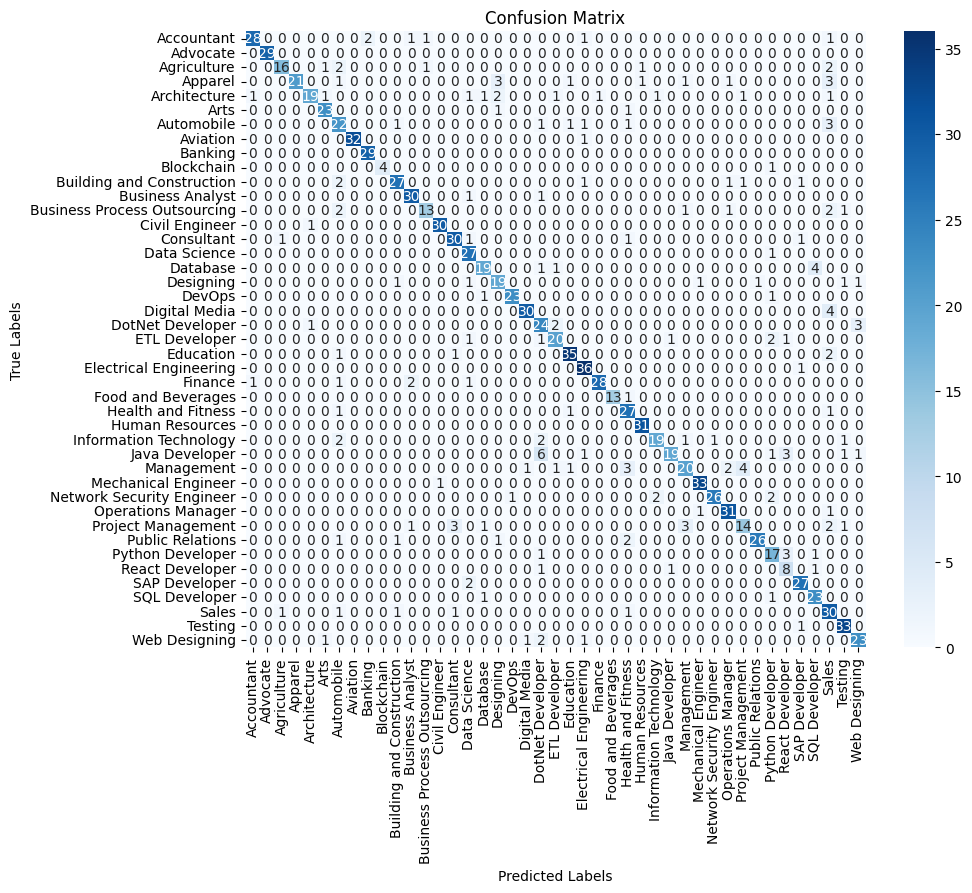

In [ ]:

# Generate confusion matrix
cm = confusion_matrix(final_test_labels.cpu(), predictions.cpu())

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

# Ensure both predictions and final_test_labels are on the same device (CPU or GPU)
predictions = predictions.to(device)
final_test_labels = final_test_labels.to(device)

# Create a dictionary to hold class-wise accuracy
class_accuracies = {}

# Loop over each label (unique job role)
for label in range(num_labels):
    # Get the indices for the current class
    indices = final_test_labels == label

    if indices.sum().item() == 0:
        class_accuracies[label] = None
        continue

    # Calculate the accuracy for the current class
    class_accuracy = accuracy_score(final_test_labels[indices].cpu(), predictions[indices].cpu())
    class_accuracies[label] = class_accuracy

# Print the accuracy for each class (job role)
for label, acc in class_accuracies.items():
    if acc is None:
        print(f'Accuracy for label {label_encoder.classes_[label]}: No samples in the test set')
    else:
        print(f'Accuracy for label {label_encoder.classes_[label]}: {acc:.4f}')


Accuracy for label Accountant: 0.8235
Accuracy for label Advocate: 1.0000
Accuracy for label Agriculture: 0.6957
Accuracy for label Apparel: 0.6562
Accuracy for label Architecture: 0.6333
Accuracy for label Arts: 0.9200
Accuracy for label Automobile: 0.7333
Accuracy for label Aviation: 0.9697
Accuracy for label Banking: 1.0000
Accuracy for label Blockchain: 0.8000
Accuracy for label Building and Construction: 0.8182
Accuracy for label Business Analyst: 0.9375
Accuracy for label Business Process Outsourcing: 0.6500
Accuracy for label Civil Engineer: 0.9677
Accuracy for label Consultant: 0.8824
Accuracy for label Data Science: 0.9643
Accuracy for label Database: 0.7600
Accuracy for label Designing: 0.7600
Accuracy for label DevOps: 0.9200
Accuracy for label Digital Media: 0.8824
Accuracy for label DotNet Developer: 0.8000
Accuracy for label ETL Developer: 0.7692
Accuracy for label Education: 0.8974
Accuracy for label Electrical Engineering: 0.9730
Accuracy for label Finance: 0.8485
Accur

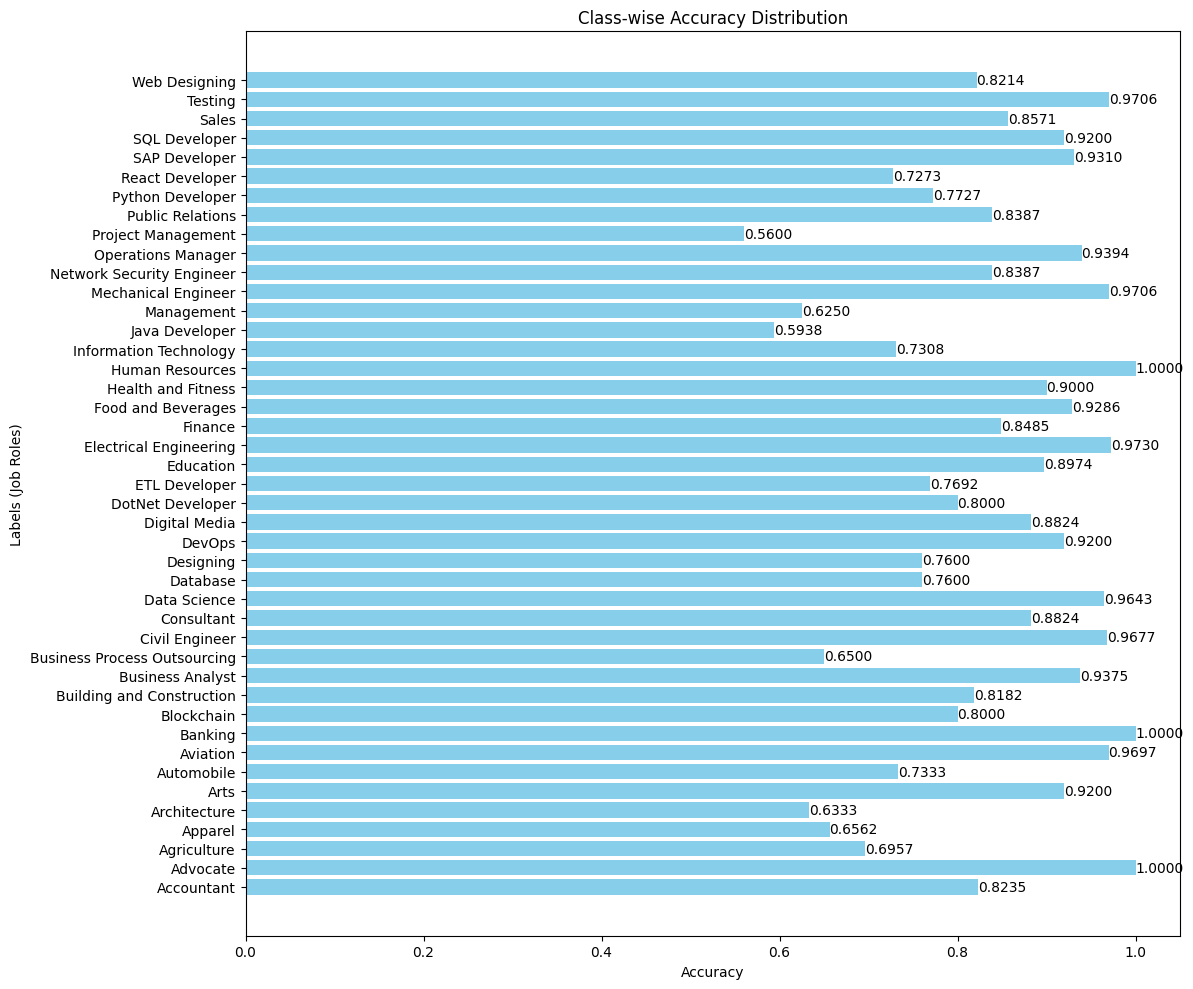

In [ ]:

# Get the accuracy values for each label
accuracies = list(class_accuracies.values())

# Use the label_encoder to get the actual class names
labels = list(label_encoder.classes_)

# Plot the distribution of accuracies
plt.figure(figsize=(12, 10))
bars = plt.barh(labels, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Labels (Job Roles)')
plt.title('Class-wise Accuracy Distribution')
plt.yticks(rotation=0)
plt.tight_layout()

# Add accuracy labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', va='center', ha='left', color='black', fontsize=10)

plt.show()


### FINAL MODEL

In [ ]:
# --- Configuration ---
EPOCHS = 3
BATCH_SIZE = 16
MAX_LENGTH = 256
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01

# After k-fold cross-validation, train a final model on the entire training data
# Train the final model on the entire training set (all data used in k-folds)
final_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
).to(device)

final_optimizer = AdamW(final_model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=WEIGHT_DECAY)

# Tokenize the entire training data
final_train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

final_train_dataset = torch.utils.data.TensorDataset(
    final_train_encodings['input_ids'],
    final_train_encodings['attention_mask'],
    torch.tensor(y_train.values)
)

final_train_loader = torch.utils.data.DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Train the model on the entire training data
final_model.train()
for epoch in range(EPOCHS):
    print(f'\nTraining Epoch {epoch + 1}/{EPOCHS} on Full Data')

    total_train_loss = 0
    train_pbar = tqdm(final_train_loader, desc='Training')

    for batch in train_pbar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        final_model.zero_grad()

        outputs = final_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)
        final_optimizer.step()

    avg_train_loss = total_train_loss / len(final_train_loader)
    print(f'Train Loss: {avg_train_loss:.4f}')

# Final evaluation on the test set using the model trained on all the data
final_model.eval()

# Tokenize the test set
final_test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

final_test_labels = torch.tensor(y_test.values).to(device)

with torch.no_grad():
    outputs = final_model(
        input_ids=final_test_encodings['input_ids'].to(device),
        attention_mask=final_test_encodings['attention_mask'].to(device)
    )

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

# Evaluate the model's performance on the test set
test_accuracy = accuracy_score(final_test_labels.cpu(), predictions.cpu())

# Print test accuracy and classification report
print(f"Test Accuracy: {test_accuracy:.4f}")
report = classification_report(final_test_labels.cpu(), predictions.cpu(), output_dict=True, zero_division=0)
print("\nClassification Report on Test Set:")
print(report)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training Epoch 1/3 on Full Data


Training: 100%|██████████| 507/507 [05:48<00:00,  1.45it/s]


Train Loss: 2.2778

Training Epoch 2/3 on Full Data


Training: 100%|██████████| 507/507 [05:47<00:00,  1.46it/s]


Train Loss: 0.6402

Training Epoch 3/3 on Full Data


Training: 100%|██████████| 507/507 [05:47<00:00,  1.46it/s]


Train Loss: 0.3859
Test Accuracy: 0.8890

Classification Report on Test Set:
{'0': {'precision': 0.9411764705882353, 'recall': 0.9411764705882353, 'f1-score': 0.9411764705882353, 'support': 34.0}, '1': {'precision': 0.9333333333333333, 'recall': 1.0, 'f1-score': 0.9655172413793104, 'support': 28.0}, '2': {'precision': 0.8888888888888888, 'recall': 0.6956521739130435, 'f1-score': 0.7804878048780488, 'support': 23.0}, '3': {'precision': 0.8709677419354839, 'recall': 0.84375, 'f1-score': 0.8571428571428571, 'support': 32.0}, '4': {'precision': 0.8571428571428571, 'recall': 0.5806451612903226, 'f1-score': 0.6923076923076923, 'support': 31.0}, '5': {'precision': 0.8518518518518519, 'recall': 0.92, 'f1-score': 0.8846153846153846, 'support': 25.0}, '6': {'precision': 0.6666666666666666, 'recall': 0.7333333333333333, 'f1-score': 0.6984126984126984, 'support': 30.0}, '7': {'precision': 0.9428571428571428, 'recall': 1.0, 'f1-score': 0.9705882352941176, 'support': 33.0}, '8': {'precision': 0.9666

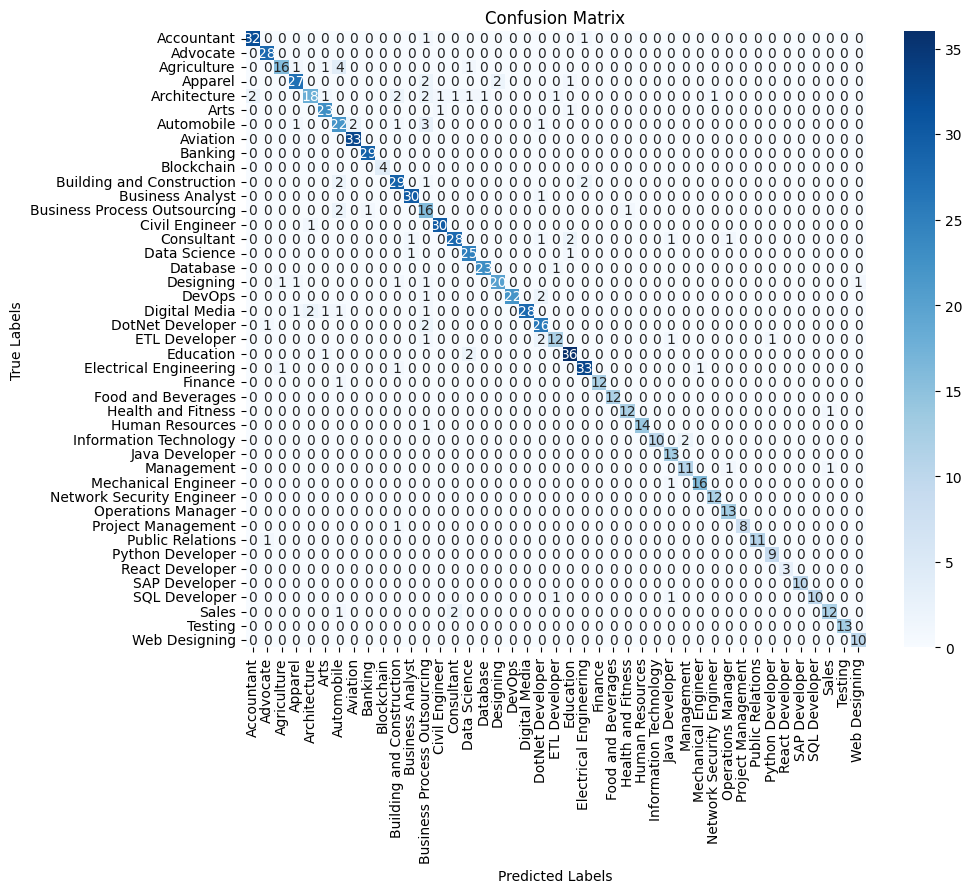

In [ ]:

# Generate confusion matrix
cm = confusion_matrix(final_test_labels.cpu(), predictions.cpu())

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Ensure both predictions and final_test_labels are on the same device (CPU or GPU)
predictions = predictions.to(device)
final_test_labels = final_test_labels.to(device)

# Identify misclassified instances
misclassified_indices = (predictions != final_test_labels).nonzero(as_tuple=True)[0]

# Move misclassified_indices to CPU to avoid issues when indexing X_test
misclassified_indices_cpu = misclassified_indices.cpu().numpy()

# Create a DataFrame with the misclassified instances
misclassified_instances = pd.DataFrame({
    'True Label': final_test_labels[misclassified_indices].cpu().numpy(),
    'Predicted Label': predictions[misclassified_indices].cpu().numpy(),
    'Text': X_test.iloc[misclassified_indices_cpu].values
})

# Show some of the misclassified instances
print(misclassified_instances.head())


   True Label  Predicted Label  \
0          23                2   
1          22               15   
2          19               12   
3           4                5   
4           6               12   

                                                Text  
0   agricultural engineer profile innovative expe...  
1   computer science teacher alissehabagmailcom m...  
2   resumesampleexamplecom  floor professional su...  
3    ca resumesampleexamplecom professional summa...  
4    floor resumesampleexamplecom summary underwr...  


In [ ]:

# Ensure both predictions and final_test_labels are on the same device (CPU or GPU)
predictions = predictions.to(device)
final_test_labels = final_test_labels.to(device)

# Create a dictionary to hold class-wise accuracy
class_accuracies = {}

# Loop over each label (unique job role)
for label in range(num_labels):
    # Get the indices for the current class
    indices = final_test_labels == label

    if indices.sum().item() == 0:
        class_accuracies[label] = None
        continue

    # Calculate the accuracy for the current class
    class_accuracy = accuracy_score(final_test_labels[indices].cpu(), predictions[indices].cpu())
    class_accuracies[label] = class_accuracy

# Print the accuracy for each class (job role)
for label, acc in class_accuracies.items():
    if acc is None:
        print(f'Accuracy for label {label_encoder.classes_[label]}: No samples in the test set')
    else:
        print(f'Accuracy for label {label_encoder.classes_[label]}: {acc:.4f}')


Accuracy for label Accountant: 0.9412
Accuracy for label Advocate: 1.0000
Accuracy for label Agriculture: 0.6957
Accuracy for label Apparel: 0.8438
Accuracy for label Architecture: 0.5806
Accuracy for label Arts: 0.9200
Accuracy for label Automobile: 0.7333
Accuracy for label Aviation: 1.0000
Accuracy for label Banking: 1.0000
Accuracy for label Blockchain: 1.0000
Accuracy for label Building and Construction: 0.8529
Accuracy for label Business Analyst: 0.9677
Accuracy for label Business Process Outsourcing: 0.8000
Accuracy for label Civil Engineer: 0.9677
Accuracy for label Consultant: 0.8235
Accuracy for label Data Science: 0.9259
Accuracy for label Database: 0.9583
Accuracy for label Designing: 0.8000
Accuracy for label DevOps: 0.8800
Accuracy for label Digital Media: 0.8235
Accuracy for label DotNet Developer: 0.8966
Accuracy for label ETL Developer: 0.7059
Accuracy for label Education: 0.9231
Accuracy for label Electrical Engineering: 0.9167
Accuracy for label Finance: 0.9231
Accur

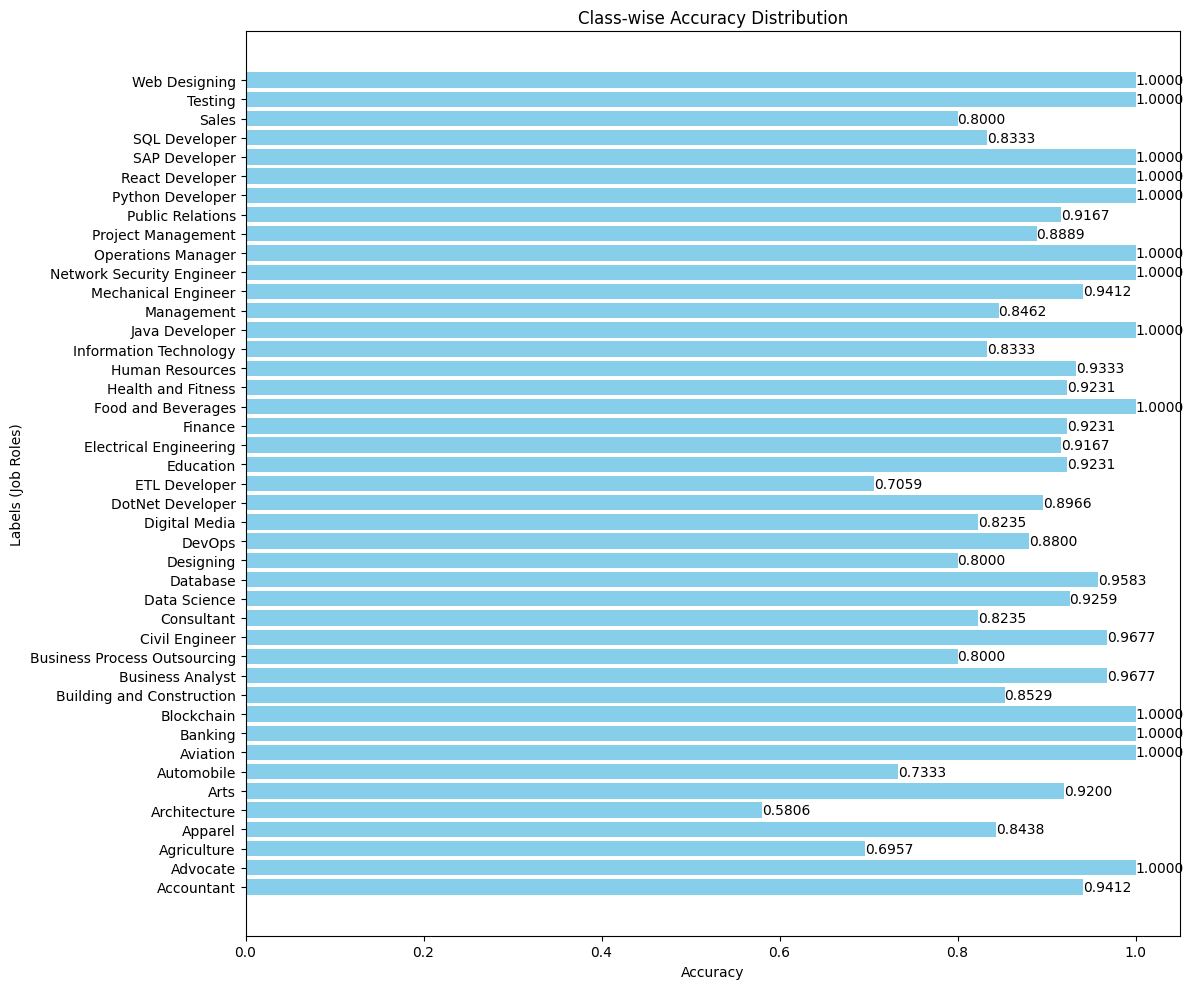

In [ ]:

# Get the accuracy values for each label
accuracies = list(class_accuracies.values())

# Use the label_encoder to get the actual class names
labels = list(label_encoder.classes_)

# Plot the distribution of accuracies
plt.figure(figsize=(12, 10))
bars = plt.barh(labels, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Labels (Job Roles)')
plt.title('Class-wise Accuracy Distribution')
plt.yticks(rotation=0)
plt.tight_layout()

# Add accuracy labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', va='center', ha='left', color='black', fontsize=10)

plt.show()


In [ ]:

def get_similarity_scores(text, model, tokenizer, label_encoder, max_length=256):
    model.eval()

    # Tokenize input
    enc = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    # Map probabilities to labels
    categories = label_encoder.inverse_transform(range(len(probs)))

    # Combine into list of tuples
    results = list(zip(categories, probs))

    # Sort by probability (descending)
    results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

    # Return top 5
    top5 = results_sorted[:5]

    # Convert to dictionary
    return {cat: float(score) for cat, score in top5}


resume_text = "Dynamic and results-driven Human Resources professional with 3 years of experience in recruitment, employee relations, and organizational development. Proven expertise in managing end-to-end recruitment processes, onboarding, performance management, and implementing HR policies to ensure a positive work culture. Strong communication and problem-solving skills with a focus on enhancing employee engagement and supporting business objectives."

scores = get_similarity_scores(
    resume_text,
    final_model,
    tokenizer,
    label_encoder,
    max_length=256
)

print(scores)



{'Human Resources': 0.9457438588142395, 'Management': 0.016285058110952377, 'Business Process Outsourcing': 0.009205315262079239, 'Aviation': 0.0036867745220661163, 'Architecture': 0.002429551910609007}


In [8]:

resume_text = "Developed a real-time Tableau dashboard to centralize yield data from external vendors, improving KPI visibility and reducing reporting turnaround. Automated data pipelines using PySpark, Python, and SQL, enabling scalable ETL processes across distributed sources. Integrated Jenkins to schedule data refreshes and streamline deployment, cutting manual workload by over 80%."

scores = get_similarity_scores(
    resume_text,
    final_model,
    tokenizer,
    label_encoder,
    max_length=256
)

print(scores)


{'ETL Developer': 0.9420120716094971, 'SQL Developer': 0.01488292682915926, 'Database': 0.008034535683691502, 'Architecture': 0.005818308796733618, 'Python Developer': 0.00560646690428257}


In [14]:


resume_text = "As a Fitness Coach at ActiveLife Wellness Center, I designed personalized workout programs for clients based on their health goals, fitness levels, and medical backgrounds. I conducted regular assessments to track progress, provided guidance on proper exercise form, and educated clients on nutrition and sustainable lifestyle habits. My role also involved leading group fitness classes, maintaining a motivating environment, and adapting sessions to accommodate different abilities and needs. Through consistent support and evidence-based training methods, I helped clients improve strength, endurance, and overall well-being."

scores = get_similarity_scores(
    resume_text,
    final_model,
    tokenizer,
    label_encoder,
    max_length=256
)

print(scores)


{'Health and Fitness': 0.9884632229804993, 'Sales': 0.0008838849025778472, 'Management': 0.0008154736133292317, 'Apparel': 0.0007246065651997924, 'Public Relations': 0.0006812604260630906}


In [11]:
# Data Science

resume_text = "As a Data Scientist at TechNova Analytics, I developed and deployed machine-learning models to support business forecasting and customer analytics initiatives. I worked closely with cross-functional teams to gather requirements, perform exploratory data analysis, and design predictive solutions that improved decision-making across marketing and product operations. My role involved building end-to-end data pipelines, engineering meaningful features, and validating model performance using statistical techniques. I also created dashboards and visual reports that helped stakeholders understand key insights and trends, resulting in more informed strategic planning."

scores = get_similarity_scores(
    resume_text,
    final_model,
    tokenizer,
    label_encoder,
    max_length=256
)

print(scores)

{'Data Science': 0.9650628566741943, 'Python Developer': 0.004203376360237598, 'DevOps': 0.002532204845920205, 'Human Resources': 0.0023230600636452436, 'ETL Developer': 0.001968610566109419}


In [ ]:
# Example text you want to classify
custom_text = ["Dynamic and results-driven Human Resources professional with [X] years of experience in recruitment, employee relations, and organizational development. Proven expertise in managing end-to-end recruitment processes, onboarding, performance management, and implementing HR policies to ensure a positive work culture. Strong communication and problem-solving skills with a focus on enhancing employee engagement and supporting business objectives."]

# Tokenize the custom text (ensure to handle the padding and truncation as needed)
custom_encodings = tokenizer(
    custom_text,
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

# Move the tokenized input to the correct device
input_ids = custom_encodings['input_ids'].to(device)
attention_mask = custom_encodings['attention_mask'].to(device)

# Make prediction with the trained model
final_model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = final_model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()  # Get the predicted class index

# Map the prediction back to the corresponding class label
predicted_label = label_encoder.classes_[prediction]

# Print the predicted label
print(f"Predicted Label: {predicted_label}")


Predicted Label: Human Resources


In [ ]:
def get_bert_embedding(text, model, tokenizer, max_length=256, device=device):
    """
    Returns a 1D tensor embedding for the given text using the BERT encoder.
    """
    model.eval()

    enc = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        # Use the underlying BERT encoder inside BertForSequenceClassification
        outputs = model.bert(**enc)  # This returns a BaseModelOutputWithPooling

        # Option 1: use pooled output (CLS-based, 768-dim)
        if outputs.pooler_output is not None:
            embedding = outputs.pooler_output  # shape: (1, hidden_size)
        else:
            # Fallback: use [CLS] token from last_hidden_state
            embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)

    # Return as 1D CPU tensor
    return embedding.squeeze(0).cpu()


import torch.nn.functional as F

def cosine_similarity_between_texts(text_a, text_b, model, tokenizer, max_length=256, device=device):
    emb_a = get_bert_embedding(text_a, model, tokenizer, max_length, device)
    emb_b = get_bert_embedding(text_b, model, tokenizer, max_length, device)

    # Convert to 2D tensors for cosine_similarity
    emb_a = emb_a.unsqueeze(0)
    emb_b = emb_b.unsqueeze(0)

    sim = F.cosine_similarity(emb_a, emb_b).item()  # value between -1 and 1
    return sim

def rank_roles_by_cosine_similarity(resume_text, role_descriptions, model, tokenizer, max_length=256, device=device):
    similarities = {}

    for role, desc in role_descriptions.items():
        sim = cosine_similarity_between_texts(
            resume_text,
            desc,
            model,
            tokenizer,
            max_length=max_length,
            device=device
        )
        similarities[role] = sim

    # Sort by similarity (highest first)
    ranked = dict(sorted(similarities.items(), key=lambda x: x[1], reverse=True))
    return ranked


In [23]:
role_descriptions = {
    "Data Scientist": """
    Responsible for building machine learning models, statistical analysis,
    working with Python, SQL, and handling large datasets to derive insights.
    """,
    "Data Analyst": """
    Focuses on data cleaning, reporting, dashboards, business intelligence,
    and tools like Excel, SQL, Power BI or Tableau.
    """,
    "Data Engineer": """
    Designs and maintains data pipelines, ETL processes, data warehouses,
    and works with tools like Spark, Hadoop, Airflow, and cloud platforms.
    """
}

resume_text = """
In this role, I designed and maintained systems that transported and transformed information across the organization. I built ETL pipelines that handled millions of records, ensuring accuracy, consistency, and reliability. My daily work involved writing optimized scripts, managing pipelines, and troubleshooting issues within distributed environments.
"""

ranked_roles = rank_roles_by_cosine_similarity(
    resume_text,
    role_descriptions,
    final_model,
    tokenizer,
    max_length=256,
    device=device
)

print(ranked_roles)



{'Data Engineer': 0.982558012008667, 'Data Analyst': 0.7332532405853271, 'Data Scientist': 0.5706653594970703}


In [20]:
role_descriptions = {
    "Data Scientist": """
    Responsible for building machine learning models, statistical analysis,
    working with Python, SQL, and handling large datasets to derive insights.
    """,
    "Data Analyst": """
    Focuses on data cleaning, reporting, dashboards, business intelligence,
    and tools like Excel, SQL, Power BI or Tableau.
    """,
    "Data Engineer": """
    Designs and maintains data pipelines, ETL processes, data warehouses,
    and works with tools like Spark, Hadoop, Airflow, and cloud platforms.
    """
}

resume_text = """
I deploy machine-learning solutions into production environments. This required monitoring model performance, troubleshooting errors, and optimizing processes to ensure reliable output. I also documented workflows and presented findings to stakeholders in a clear and actionable manner.
"""

ranked_roles = rank_roles_by_cosine_similarity(
    resume_text,
    role_descriptions,
    final_model,
    tokenizer,
    max_length=256,
    device=device
)

print(ranked_roles)



{'Data Analyst': 0.6179133057594299, 'Data Scientist': 0.29386210441589355, 'Data Engineer': 0.2097213864326477}


In [21]:
role_descriptions = {
    "Data Scientist": """
    Responsible for building machine learning models, statistical analysis,
    working with Python, SQL, and handling large datasets to derive insights.
    """,
    "Data Analyst": """
    Focuses on data cleaning, reporting, dashboards, business intelligence,
    and tools like Excel, SQL, Power BI or Tableau.
    """,
    "Data Engineer": """
    Designs and maintains data pipelines, ETL processes, data warehouses,
    and works with tools like Spark, Hadoop, Airflow, and cloud platforms.
    """
}

resume_text = """
In this role, I examined business datasets to uncover trends, issues, and improvement opportunities. I produced weekly and monthly reports that summarized performance indicators and helped operational teams understand how their strategies were performing. My work involved scripting, query optimization, and reviewing data for inconsistencies.
"""

ranked_roles = rank_roles_by_cosine_similarity(
    resume_text,
    role_descriptions,
    final_model,
    tokenizer,
    max_length=256,
    device=device
)

print(ranked_roles)



{'Data Analyst': 0.7730448246002197, 'Data Scientist': 0.48317208886146545, 'Data Engineer': 0.45700210332870483}
